### New attempt
Old accuracy: 81,83026200325937

In [26]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch.optim as optim
from torch.nn import functional as F

import zipfile

# Path to the ZIP file
zip_file_path = 'train.csv.zip'

# Open the ZIP file and list its contents
with zipfile.ZipFile(zip_file_path, 'r') as z:
    # List all files in the ZIP archive
    file_list = z.namelist()
    print("Files in ZIP archive:", file_list)
    
    # Extract the specific CSV file
    csv_file_name = 'train.csv'
    with z.open(csv_file_name) as f:
        train_pd = pd.read_csv(f)

train_pd.head()

Files in ZIP archive: ['train.csv', '__MACOSX/._train.csv']


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47
0,9,0.253,0.303,0.353,0.37475,0.39650,0.41825,0.440,0.42425,0.40850,...,0.42400,0.41400,0.4040,0.394,0.420,0.391,0.3825,0.374,0.338,0.331
1,1,0.228,0.210,0.220,0.22167,0.22333,0.22500,0.275,0.24000,0.23233,...,0.53300,0.42000,0.3070,0.333,0.355,0.355,0.3520,0.349,0.370,0.391
2,9,0.281,0.244,0.278,0.33150,0.38500,0.35100,0.564,0.67100,0.67667,...,0.60033,0.57367,0.5470,0.479,0.505,0.475,0.4520,0.429,0.432,0.435
3,1,0.203,0.200,0.197,0.14400,0.18600,0.22800,0.233,0.20300,0.20267,...,0.53750,0.46000,0.3825,0.305,0.304,0.274,0.2595,0.245,0.197,0.149
4,14,0.289,0.369,0.449,0.43700,0.48600,0.53500,0.383,0.27000,0.25667,...,0.62900,0.64100,0.6530,0.610,0.635,0.511,0.4365,0.362,0.374,0.348


In [33]:
batch_size = 64
n_iters = 10000
num_epochs = 200
# Create CNN Model
n_timesteps = 46
n_outputs = 20

n = 199424 # number of samples less than 199424

y_np = train_pd.V1.values[:n]
x_np = train_pd.loc[:,train_pd.columns != "V1"].values[:n, :]
y_np = y_np - 1
# y goes from 0 to 19

x_train_np, x_test_np, y_train_np, y_test_np = train_test_split(x_np, y_np, test_size=0.2) 

x_train_tensor = torch.from_numpy(x_train_np).type(torch.FloatTensor)
y_train_tensor = torch.from_numpy(y_train_np).type(torch.LongTensor)

x_test_tensor = torch.from_numpy(x_test_np).type(torch.FloatTensor)
y_test_tensor = torch.from_numpy(y_test_np).type(torch.LongTensor)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
test = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        x = x.unsqueeze(1)
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return h0, c0

In [36]:
input_dim = 46   
hidden_dim = 128
layer_dim = 1
output_dim = 20
seq_dim = 128

lr = 0.001
n_epochs = 500
#iterations_per_epoch = 500
best_acc = 0
patience, trials = 20, 0

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)

criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)


### Runnare questo

In [37]:
print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    for i, (x_batch, y_batch) in enumerate(train_loader):
        model.train()

        opt.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()
    
    model.eval()
    correct, total = 0, 0
    for x_val, y_val in test_loader:
        out = model(x_val)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_val.size(0)
        correct += (preds == y_val).sum().item()
    
    acc = correct / total

    if epoch % 500 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Start model training
Epoch 1 best model saved with accuracy: 66.83%
Epoch 2 best model saved with accuracy: 69.10%
Epoch 3 best model saved with accuracy: 70.62%
Epoch 4 best model saved with accuracy: 71.71%
Epoch 5 best model saved with accuracy: 72.47%
Epoch 6 best model saved with accuracy: 73.09%
Epoch 7 best model saved with accuracy: 73.59%
Epoch 8 best model saved with accuracy: 73.97%
Epoch 9 best model saved with accuracy: 74.36%
Epoch 10 best model saved with accuracy: 74.74%
Epoch 11 best model saved with accuracy: 75.03%
Epoch 12 best model saved with accuracy: 75.26%
Epoch 13 best model saved with accuracy: 75.47%
Epoch 14 best model saved with accuracy: 75.71%
Epoch 15 best model saved with accuracy: 75.87%
Epoch 16 best model saved with accuracy: 76.07%
Epoch 17 best model saved with accuracy: 76.31%
Epoch 18 best model saved with accuracy: 76.48%
Epoch 19 best model saved with accuracy: 76.61%
Epoch 20 best model saved with accuracy: 76.75%
Epoch 21 best model saved wi

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import KFold
import numpy as np
from itertools import product

# Define the hyperparameters to tune
param_grid = {
    'input_dim': [46],
    'hidden_dim': [128, 256, 512],
    'layer_dim': [1, 2],
    'output_dim': [20],
    'seq_dim': [128],
    'lr': [0.001, 0.0005],
    'batch_size': [64, 128],
    'n_epochs': [100, 200],
    'patience': [10, 20]
}

# Create a list of all possible hyperparameter combinations
param_combinations = list(product(*param_grid.values()))

# Assuming your dataset is already loaded into x_np and y_np
x_np = train_pd.loc[:, train_pd.columns != "V1"].values
y_np = train_pd.V1.values - 1  # Adjust labels if necessary

# Convert numpy arrays to PyTorch tensors
x_tensor = torch.from_numpy(x_np).type(torch.FloatTensor)
y_tensor = torch.from_numpy(y_np).type(torch.LongTensor)

# Create TensorDataset
dataset = TensorDataset(x_tensor, y_tensor)

# Define KFold cross-validator
kfold = KFold(n_splits=5, shuffle=True)

# Function to train and evaluate the model
def train_and_evaluate(params):
    input_dim, hidden_dim, layer_dim, output_dim, seq_dim, lr, batch_size, n_epochs, patience = params
    best_acc = 0
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
        model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
        
        best_fold_acc = 0
        trials = 0
        
        for epoch in range(1, n_epochs + 1):
            model.train()
            for x_batch, y_batch in train_loader:
                optimizer.zero_grad()
                out = model(x_batch)
                loss = criterion(out, y_batch)
                loss.backward()
                optimizer.step()
            
            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for x_val, y_val in val_loader:
                    out = model(x_val)
                    preds = torch.argmax(out, dim=1)
                    total += y_val.size(0)
                    correct += (preds == y_val).sum().item()
            
            acc = correct / total
            
            if acc > best_fold_acc:
                trials = 0
                best_fold_acc = acc
                if acc > best_acc:
                    best_acc = acc
            else:
                trials += 1
                if trials >= patience:
                    break
    
    return best_acc

# Perform grid search
best_params = None
best_score = 0

for params in param_combinations:
    score = train_and_evaluate(params)
    if score > best_score:
        best_score = score
        best_params = params

print(f'Best Hyperparameters: {best_params}')
print(f'Best Accuracy: {best_score:.2%}')

KeyboardInterrupt: 

In [25]:
best_params

(46, 128, 1, 20, 128, 0.001, 64, 200, 20)

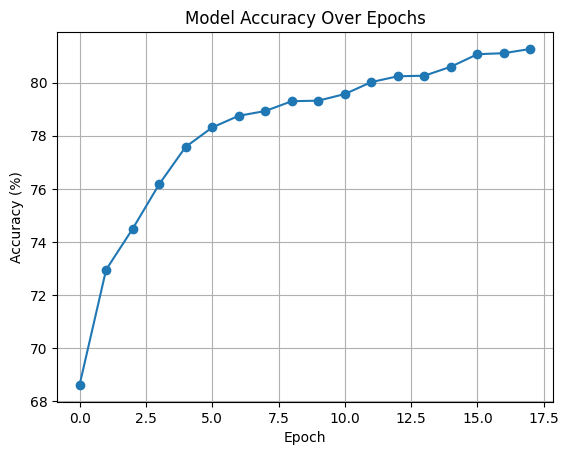

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy values extracted from the provided text
accuracy_values = [
    68.61, 72.95, 74.49, 76.17, 77.58, 78.31, 78.75, 78.93, 79.30, 79.32,
    79.57, 80.02, 80.24, 80.26, 80.60, 81.07, 81.11, 81.27
]

# Create a 1D vector
accuracy_vector = np.array(accuracy_values)

# Plot the accuracy values
plt.plot(accuracy_vector, marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()